# Machine Learning Practical: Coursework 2
## Experiment 3/3: Stacked Autoencoders

**Due date: 16:00 Thursday 24th November 2016**

# Georgios Pligoropoulos - s1687568

In [1]:
import sys
mlpdir = '/home/student/Dropbox/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
sys.path.append(mlpdir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import itertools

#%matplotlib notebook
%matplotlib inline

In [3]:
from mlp.data_providers import MNISTDataProvider, MNISTAutoencoderDataProvider, StackedAutoEncoderDataProvider

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, MaxPoolingLayer, DropoutLayer, ReluLayer

from mlp.errors import CrossEntropySoftmaxError, SumOfSquaredDiffsError

from mlp.models import MultipleLayerModel

from mlp.initialisers import ConstantInit, GlorotUniformInit

from mlp.optimisers import Optimiser

from mlp.learning_rules import GradientDescentLearningRule, MomentumLearningRule, AdamLearningRule, \
    AdaGradLearningRule, RmsPropLearningRule
    
from mlp.schedulers import AnnealedDropoutScheduler, MomentumCoefficientScheduler, ConstantLearningRateScheduler,\
    ReciprocalLearningRateScheduler, ExponentialLearningRateScheduler

In [4]:
def trainModel(model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers=[]):
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, schedulers = schedulers)

    # Run the optimiser for some number of epochs (full passes through the training set)
    # printing statistics every epoch
    stats, keys, runTime = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    #stats = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    return stats, keys, runTime

In [5]:
def plotStats(stats, keys, stats_interval):
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return fig_1, ax_1, fig_2, ax_2

In [6]:
def getFinalValues(statistics):
    lastStats = statistics[-1]
    return {
        "Final Training Error": lastStats[0],
        "Final Training Accuracy": lastStats[1],
        "Final Testing Error": lastStats[2],
        "Final Testing Accuracy": lastStats[3],
    }

In [7]:
# Seed a random number generator
seed = 16011984
rng = np.random.RandomState(seed)

In [8]:
batchSize = 50

Note: When in our explanations refer to **accuracy** we mean the final validation accuracy and when we refer to **performance** we mean how fast we reached the optimal accuracy for the current experiment

In [1]:
figcount = 0

# Grand Experiment 3: Stacked Autoencoders Pretraining

In this experiment we are going to use stacked autoencoders to optimize the pretraining of our neural network.

Our intentions is a pretraining that is going to have two positive effects:

1) For large architectures with many layers there is the issue that the backpropagation is more "slow". This is understandable because we have many layers and in order for the error to propagate properly backwards and set the weights at a good level we might have saturations or other effects that cause very slow learning at the first epochs.  
We are going to test that by running an experiment with six or more layers where the slow-learning effect is apparent and then repeat the experiment with our stacked autoencoders pretraining. The expectation is that our pretraining will not go through this phase of slow learning and the learning process is converge more quickly.

2) We should get a very good performance always in comparison to random initialization of the weights.  
We are going to test that by repeating the same experiment a few times for various random initializations of the weights. Then for the same architecture we are going to pretrain the network using stacked autoencoders and run to see the final error and accuracy of both training and validation set. We must see that this pretraining yields better or equally good results as the best of the cases with the random initializations.


In [9]:
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

In [10]:
statsInterval = 5

### Implementing both Linear and Non-Linear Stacked Autoencoders

In Autoencoders we need the error to be the difference between output and input. We are not doing classification that is why we are going to use as error the Sum of Squared Differences

We are going to use the best implementation of our adaptive learning rule which is Adam Learning Rule with default parameters

We are implementing both a linear and a non-linear autoencoder.

Our Linear autoencoder is going to have a ReLU layer for the output of the first Affine layer and a Sigmoid layer for the output of the second Affine layer

In [60]:
def executeNonLinearAutoencoder(inputOutputDim, hiddenDim, dataProvider,
                                numEpochs=30, error = SumOfSquaredDiffsError(),
                               nonLinearLayer1 = SigmoidLayer(), nonLinearLayer2=SigmoidLayer()):
    learningRule = AdamLearningRule() # default params
    
    model = MultipleLayerModel([
        AffineLayer(inputOutputDim, hiddenDim, weightsInit, biasesInit),
        nonLinearLayer1, #ReluLayer(),
        AffineLayer(hiddenDim, inputOutputDim, weightsInit, biasesInit),
        nonLinearLayer2 #SigmoidLayer()
    ])
    
    stats, keys, runTime = trainModel(
        model=model,
        error=error, 
        learning_rule = learningRule,
        train_data = dataProvider,
        valid_data = None,
        num_epochs = numEpochs,
        stats_interval = statsInterval
    )
    
    def dropUnnecessaryAutoencoderLayers(model):
        return MultipleLayerModel(model.layers[:-2])
    #dropUnnecessaryAutoencoderLayers = lambda model: MultipleLayerModel(model.layers[:-2]) #one liner

    return dropUnnecessaryAutoencoderLayers(model), stats, keys, runTime

In [61]:
def executeLinearAutoencoder(inputOutputDim, hiddenDim, dataProvider,
                             numEpochs=30, error = SumOfSquaredDiffsError()):
    learningRule = AdamLearningRule() # default params
    
    model = MultipleLayerModel([
        AffineLayer(inputOutputDim, hiddenDim, weightsInit, biasesInit),
        AffineLayer(hiddenDim, inputOutputDim, weightsInit, biasesInit)
    ])
    
    stats, keys, runTime = trainModel(
        model=model,
        error=error, 
        learning_rule = learningRule,
        train_data = dataProvider,
        valid_data = None,
        num_epochs = numEpochs,
        stats_interval = statsInterval
    )
    
    def dropUnnecessaryAutoencoderLayers(model):
        return MultipleLayerModel(model.layers[:-1])

    return dropUnnecessaryAutoencoderLayers(model), stats, keys, runTime

In [62]:
def concatenateModels(models):
    layersCollection = [model.layers for model in models]
    flattenLayers = sum(layersCollection, []) #np.array(layersCollection).flatten()
    return MultipleLayerModel(flattenLayers)

In [63]:
def constructModelFromPretrainedByAutoEncoderStack(hiddenDimLayers, autoencoder, inputDim = 784,
                                                   batchSize=batchSize, rng=rng):
    #preTrainedModels = []
    curInputDim = inputDim
    curModel = None
    for hiddenDimLayer in hiddenDimLayers:
        dataProvider = StackedAutoEncoderDataProvider('train', batch_size=batchSize, rng=rng, model=curModel)
        preTrainedModel, stats, keys, runTime = autoencoder(curInputDim, hiddenDimLayer, dataProvider)

        curInputDim = hiddenDimLayer
        curModel = preTrainedModel if curModel is None else concatenateModels([curModel, preTrainedModel])
        #preTrainedModels.append(model)
        
    return curModel

StackedAutoEncoderDataProvider is a special data provider which extends the MNISTDataProvider with one extra parameter: the model

Recall that for autoencoders we need only the input data therefore the output classificaiton is neglected, ignored.

If model is None then the StackedAutoEncoderDataProvider falls back to a simple MNISTDataProvider which returns the inputs as inputs and ouputs.

When model is set then the inputs are transformed. The inputs are passing through all the layers of the model with the *fprop* method and this representation is returned as both inputs and outputs.

Therefore we are capable to use this implementation for any layer of our stacked autoencoder.

## Experiment: avoiding slow learning effects on multi-layer neural networks with many layers

In [15]:
weightsInit = GlorotUniformInit(rng=rng)
biasesInit = ConstantInit(0.)

In [16]:
# Create data provider objects for the MNIST data set
trainData = MNISTDataProvider('train', batch_size=batchSize, rng=rng)
validData = MNISTDataProvider('valid', batch_size=batchSize, rng=rng)

### Six Layers

Epoch 0:
  error(train)=2.48e+00, acc(train)=1.14e-01, error(valid)=2.49e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.35s to complete
  error(train)=2.31e+00, acc(train)=9.90e-02, error(valid)=2.31e+00, acc(valid)=9.67e-02, params_penalty=0.00e+00
Epoch 10: 2.17s to complete
  error(train)=2.31e+00, acc(train)=1.02e-01, error(valid)=2.31e+00, acc(valid)=1.03e-01, params_penalty=0.00e+00
Epoch 15: 2.12s to complete
  error(train)=2.14e-01, acc(train)=9.45e-01, error(valid)=2.21e-01, acc(valid)=9.43e-01, params_penalty=0.00e+00
Epoch 20: 2.38s to complete
  error(train)=8.40e-02, acc(train)=9.77e-01, error(valid)=1.34e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 25: 5.97s to complete
  error(train)=6.76e-02, acc(train)=9.81e-01, error(valid)=1.37e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 30: 4.71s to complete
  error(train)=2.77e-02, acc(train)=9.93e-01, error(valid)=1.18e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 35: 5.09s to complet

Run Time:
142.453700066


{'Final Testing Accuracy': 0.97269999999999879,
 'Final Testing Error': 0.13372424297570024,
 'Final Training Accuracy': 0.99632000000000209,
 'Final Training Error': 0.014629709726267197}

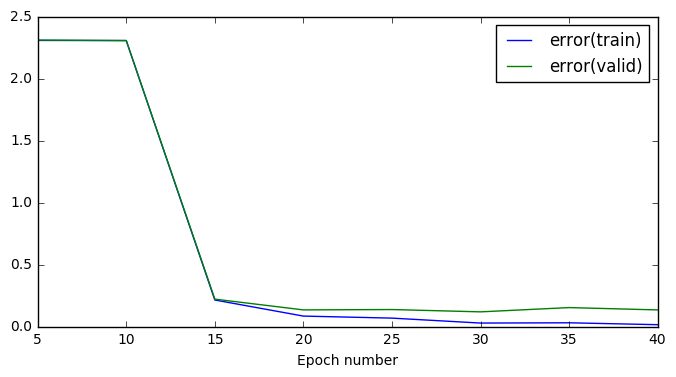

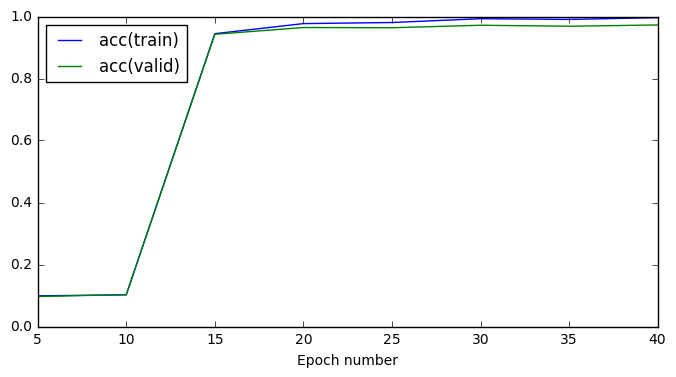

In [68]:
num_epochs = 40

input_dim, output_dim, hidden_dim = 784, 10, 100

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weightsInit, biasesInit),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weightsInit, biasesInit)
])

learning_rate = 1.1
learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(model, error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_6_layers_100_per_layer_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_6_layers_100_per_layer_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

Now let's construct a model of six layers with 100 dimensionality in each hidden layer via a Linear Stacked AutoEncoder

In [39]:
#hiddenDims = np.repeat(100, 5)
hiddenDims = np.concatenate( (np.repeat(100, 5), np.array([10])) )
hiddenDims

array([100, 100, 100, 100, 100,  10])

In [35]:
model = constructModelFromPretrainedByAutoEncoderStack(hiddenDims, executeLinearAutoencoder)

Epoch 0:
  error(train)=6.05e+01, acc(train)=1.30e-03, params_penalty=0.00e+00
Epoch 5: 4.47s to complete
  error(train)=2.33e+00, acc(train)=1.46e-02, params_penalty=0.00e+00
Epoch 10: 4.02s to complete
  error(train)=2.31e+00, acc(train)=1.41e-02, params_penalty=0.00e+00
Epoch 15: 4.38s to complete
  error(train)=2.33e+00, acc(train)=1.47e-02, params_penalty=0.00e+00
Epoch 20: 4.01s to complete
  error(train)=2.30e+00, acc(train)=1.43e-02, params_penalty=0.00e+00
Epoch 25: 4.16s to complete
  error(train)=2.29e+00, acc(train)=1.47e-02, params_penalty=0.00e+00
Epoch 30: 4.01s to complete
  error(train)=2.29e+00, acc(train)=1.47e-02, params_penalty=0.00e+00
Epoch 0:
  error(train)=5.94e+00, acc(train)=7.80e-03, params_penalty=0.00e+00
Epoch 5: 0.81s to complete
  error(train)=2.29e-30, acc(train)=1.00e+00, params_penalty=0.00e+00
Epoch 10: 0.76s to complete
  error(train)=4.62e-04, acc(train)=9.92e-01, params_penalty=0.00e+00
Epoch 15: 0.82s to complete
  error(train)=2.46e-04, acc(tra

Constructing layer by layer our model by including Sigmoid Layers for non-linearities among our stacked layers from the stacked autoencoder process

In [40]:
reconstructedModel = MultipleLayerModel([
    model.layers[0],
    SigmoidLayer(),
    model.layers[1], 
    SigmoidLayer(),
    model.layers[2], 
    SigmoidLayer(),
    model.layers[3], 
    SigmoidLayer(),
    model.layers[4],
    SigmoidLayer(),
    model.layers[5]
])

Epoch 0:
  error(train)=2.34e+00, acc(train)=9.94e-02, error(valid)=2.34e+00, acc(valid)=9.90e-02, params_penalty=0.00e+00
Epoch 5: 1.99s to complete
  error(train)=2.31e+00, acc(train)=9.86e-02, error(valid)=2.31e+00, acc(valid)=9.91e-02, params_penalty=0.00e+00
Epoch 10: 2.01s to complete
  error(train)=5.82e-01, acc(train)=8.52e-01, error(valid)=5.56e-01, acc(valid)=8.62e-01, params_penalty=0.00e+00
Epoch 15: 2.00s to complete
  error(train)=1.48e-01, acc(train)=9.62e-01, error(valid)=1.83e-01, acc(valid)=9.55e-01, params_penalty=0.00e+00
Epoch 20: 2.22s to complete
  error(train)=6.01e-02, acc(train)=9.84e-01, error(valid)=1.23e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 25: 2.01s to complete
  error(train)=3.45e-02, acc(train)=9.91e-01, error(valid)=1.18e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 30: 2.23s to complete
  error(train)=2.97e-02, acc(train)=9.92e-01, error(valid)=1.26e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 2.12s to complet

Run Time:
95.1159470081


{'Final Testing Accuracy': 0.96999999999999797,
 'Final Testing Error': 0.13389272142721168,
 'Final Training Accuracy': 0.99524000000000246,
 'Final Training Error': 0.018037351713987373}

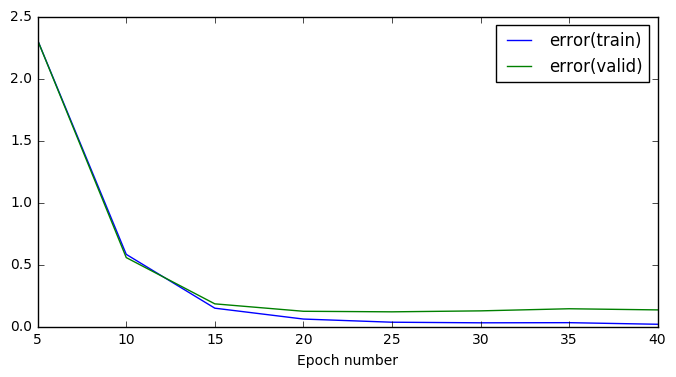

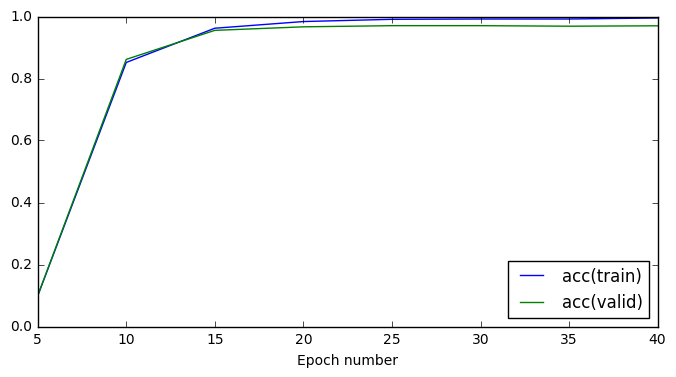

In [41]:
num_epochs = 40

learningRate = 1.1

learningRule = GradientDescentLearningRule(learning_rate=learningRate)

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

learning_rate = 1.1
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(
    reconstructedModel,
    error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_6_layers_100_per_layer_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_6_layers_100_per_layer_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

Gladly the experiment is in consice with our original intentions. Here we don't see a slow learning rate at the beginning but rather an immediate increase of the accuracy and decrease of the error.

In other words we don't see a flat line in the plot. The pretraining has yield a neural network which is more appropriate for our final classification

### Seven Layers

Epoch 0:
  error(train)=2.62e+00, acc(train)=1.14e-01, error(valid)=2.61e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.30s to complete
  error(train)=2.30e+00, acc(train)=1.14e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 10: 2.36s to complete
  error(train)=2.31e+00, acc(train)=9.94e-02, error(valid)=2.31e+00, acc(valid)=9.90e-02, params_penalty=0.00e+00
Epoch 15: 2.44s to complete
  error(train)=2.31e+00, acc(train)=9.98e-02, error(valid)=2.31e+00, acc(valid)=9.61e-02, params_penalty=0.00e+00
Epoch 20: 2.32s to complete
  error(train)=2.31e+00, acc(train)=9.86e-02, error(valid)=2.31e+00, acc(valid)=9.91e-02, params_penalty=0.00e+00
Epoch 25: 2.45s to complete
  error(train)=2.30e+00, acc(train)=1.02e-01, error(valid)=2.30e+00, acc(valid)=1.03e-01, params_penalty=0.00e+00
Epoch 30: 2.38s to complete
  error(train)=2.31e+00, acc(train)=9.90e-02, error(valid)=2.31e+00, acc(valid)=9.67e-02, params_penalty=0.00e+00
Epoch 35: 2.29s to complet

Run Time:
272.437316895


{'Final Testing Accuracy': 0.97219999999999862,
 'Final Testing Error': 0.16651949299521823,
 'Final Training Accuracy': 0.99846000000000079,
 'Final Training Error': 0.0080224904808417347}

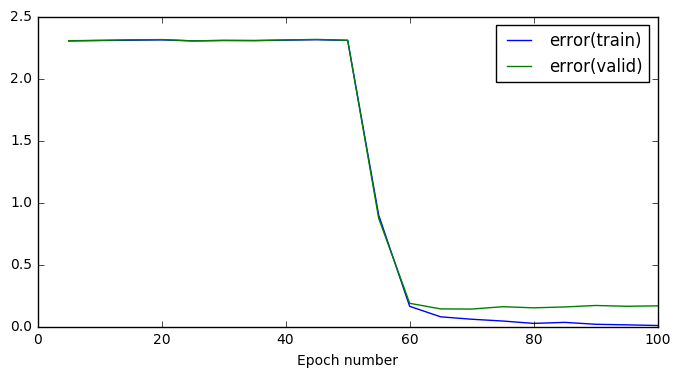

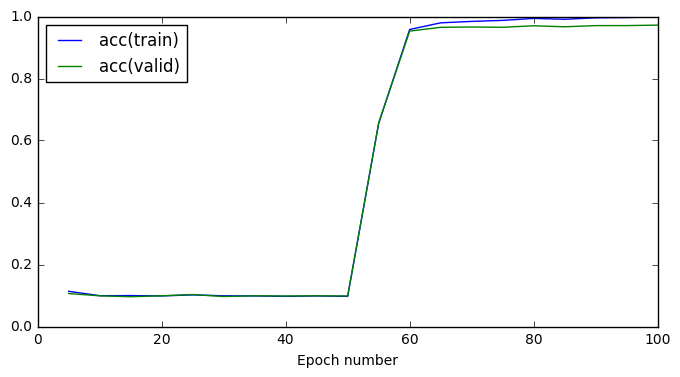

In [43]:
num_epochs = 100

learningRate = 1.1
learningRule = GradientDescentLearningRule(learning_rate=learningRate)

input_dim, output_dim, hidden_dim = 784, 10, 100

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weightsInit, biasesInit),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weightsInit, biasesInit), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weightsInit, biasesInit)
])

stats, keys, runTime = trainModel(model, error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_7_layers_100_per_layer_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_7_layers_100_per_layer_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

With 7 layers the effect is more severe. The learning is really slow in the beginning and we have to go to more than 50 epochs so that the neural network really starts learning

Now let's construct a model of seven layers with 100 dimensionality in each hidden layer via a Linear Stacked AutoEncoder and see if we are going to alieviate this unwanted effect

In [44]:
#hiddenDims = np.repeat(100, 5)
hiddenDims = np.concatenate( (np.repeat(100, 6), np.array([10])) )
hiddenDims

array([100, 100, 100, 100, 100, 100,  10])

In [45]:
model = constructModelFromPretrainedByAutoEncoderStack(hiddenDims, executeLinearAutoencoder)

Epoch 0:
  error(train)=6.05e+01, acc(train)=1.40e-03, params_penalty=0.00e+00
Epoch 5: 3.98s to complete
  error(train)=2.31e+00, acc(train)=1.45e-02, params_penalty=0.00e+00
Epoch 10: 3.64s to complete
  error(train)=2.31e+00, acc(train)=1.47e-02, params_penalty=0.00e+00
Epoch 15: 3.64s to complete
  error(train)=2.31e+00, acc(train)=1.49e-02, params_penalty=0.00e+00
Epoch 20: 3.78s to complete
  error(train)=2.30e+00, acc(train)=1.43e-02, params_penalty=0.00e+00
Epoch 25: 3.73s to complete
  error(train)=2.30e+00, acc(train)=1.43e-02, params_penalty=0.00e+00
Epoch 30: 3.61s to complete
  error(train)=2.29e+00, acc(train)=1.48e-02, params_penalty=0.00e+00
Epoch 0:
  error(train)=6.34e+00, acc(train)=5.64e-03, params_penalty=0.00e+00
Epoch 5: 0.76s to complete
  error(train)=1.86e-30, acc(train)=1.00e+00, params_penalty=0.00e+00
Epoch 10: 0.81s to complete
  error(train)=1.92e-04, acc(train)=9.93e-01, params_penalty=0.00e+00
Epoch 15: 0.76s to complete
  error(train)=5.13e-04, acc(tra

Constructing layer by layer our model by including Sigmoid Layers for non-linearities among our stacked layers from the stacked autoencoder process

In [49]:
for l in model.layers:
    print l.params[0].shape

(100, 784)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(10, 100)


In [53]:
reconstructedModel = MultipleLayerModel([
    model.layers[0],
    SigmoidLayer(),
    model.layers[1], 
    SigmoidLayer(),
    model.layers[2], 
    SigmoidLayer(),
    model.layers[3], 
    SigmoidLayer(),
    model.layers[4],
    SigmoidLayer(),
    model.layers[5],
    SigmoidLayer(),
    model.layers[6]
])

Epoch 0:
  error(train)=2.30e+00, acc(train)=1.14e-01, error(valid)=2.31e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.34s to complete
  error(train)=2.31e+00, acc(train)=9.90e-02, error(valid)=2.31e+00, acc(valid)=9.67e-02, params_penalty=0.00e+00
Epoch 10: 2.80s to complete
  error(train)=2.31e+00, acc(train)=1.03e-01, error(valid)=2.31e+00, acc(valid)=1.09e-01, params_penalty=0.00e+00
Epoch 15: 2.46s to complete
  error(train)=2.30e+00, acc(train)=1.14e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 20: 2.74s to complete
  error(train)=2.31e+00, acc(train)=1.14e-01, error(valid)=2.31e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 25: 2.60s to complete
  error(train)=2.31e+00, acc(train)=1.14e-01, error(valid)=2.31e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 30: 3.58s to complete
  error(train)=2.31e+00, acc(train)=1.14e-01, error(valid)=2.31e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 35: 2.38s to complet

Run Time:
362.918326139


{'Final Testing Accuracy': 0.96699999999999886,
 'Final Testing Error': 0.18598357700426849,
 'Final Training Accuracy': 0.99698000000000186,
 'Final Training Error': 0.010658858796578427}

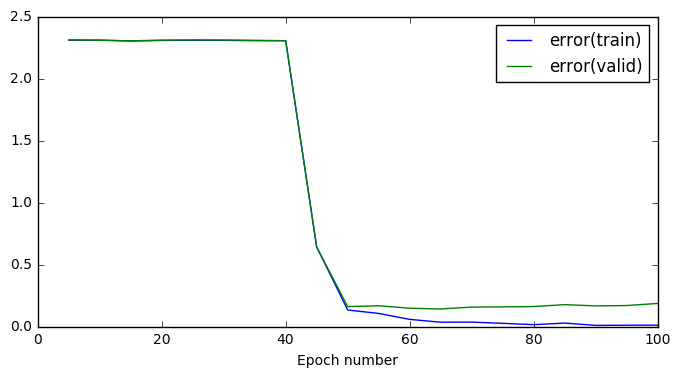

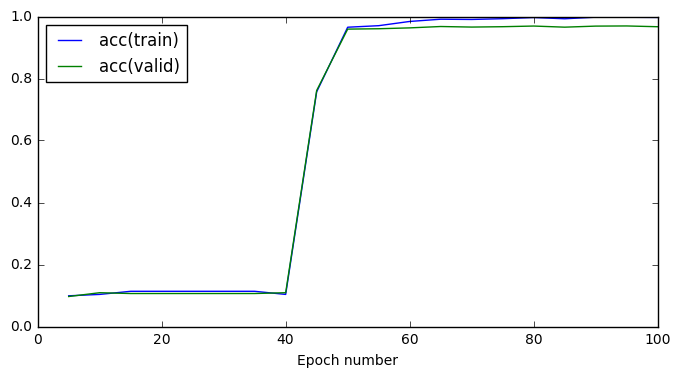

In [54]:
num_epochs = 100

learningRate = 1.1
learningRule = GradientDescentLearningRule(learning_rate=learningRate)

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

stats, keys, runTime = trainModel(
    reconstructedModel,
    error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_7_layers_100_per_layer_linear_pretrain_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_7_layers_100_per_layer_linear_pretrain_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

Here having 7 layer the effect is so severe that our pretraining with the linear stacked autoencoder is not enough to bring the pretraining to an optimal state.

However comparing this experiment and the previous one we see that we did better. Previous at 50 epochs we had done no real progress on learning. In the current experiment after 40 epochs the system has already gone through that slow-learning phase and it is learning in a fast rate.

Let's try with the non linear stacked autoencoder to see if we can yield better results

In [64]:
model = constructModelFromPretrainedByAutoEncoderStack(hiddenDims, executeNonLinearAutoencoder)

Epoch 0:
  error(train)=9.12e+01, acc(train)=2.34e-03, params_penalty=0.00e+00
Epoch 5: 4.78s to complete
  error(train)=3.97e+00, acc(train)=1.20e-02, params_penalty=0.00e+00
Epoch 10: 4.83s to complete
  error(train)=2.18e+00, acc(train)=1.40e-02, params_penalty=0.00e+00
Epoch 15: 5.01s to complete
  error(train)=1.32e+00, acc(train)=1.36e-02, params_penalty=0.00e+00
Epoch 20: 5.01s to complete
  error(train)=1.11e+00, acc(train)=1.36e-02, params_penalty=0.00e+00
Epoch 25: 4.98s to complete
  error(train)=1.00e+00, acc(train)=1.45e-02, params_penalty=0.00e+00
Epoch 30: 5.92s to complete
  error(train)=9.45e-01, acc(train)=1.45e-02, params_penalty=0.00e+00
Epoch 0:
  error(train)=3.77e+00, acc(train)=6.76e-03, params_penalty=0.00e+00
Epoch 5: 1.17s to complete
  error(train)=1.31e-01, acc(train)=4.09e-01, params_penalty=0.00e+00
Epoch 10: 1.25s to complete
  error(train)=5.35e-02, acc(train)=5.69e-01, params_penalty=0.00e+00
Epoch 15: 1.26s to complete
  error(train)=4.24e-02, acc(tra

Let's drop the last sigmoid layer that we don't need it (we use Softmax instead)

In [67]:
# for l in model.layers:
#     print l.params[0].shape
reconstructedModel = MultipleLayerModel(model.layers[:-1])
len(reconstructedModel.layers)

13

Epoch 0:
  error(train)=2.51e+00, acc(train)=1.10e-01, error(valid)=2.49e+00, acc(valid)=1.10e-01, params_penalty=0.00e+00
Epoch 5: 2.30s to complete
  error(train)=6.65e-02, acc(train)=9.80e-01, error(valid)=1.09e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 10: 2.30s to complete
  error(train)=2.57e-02, acc(train)=9.92e-01, error(valid)=9.33e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 15: 2.38s to complete
  error(train)=3.14e-02, acc(train)=9.90e-01, error(valid)=1.18e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.49s to complete
  error(train)=2.51e-02, acc(train)=9.91e-01, error(valid)=1.38e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 25: 2.65s to complete
  error(train)=9.52e-03, acc(train)=9.97e-01, error(valid)=1.27e-01, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 30: 2.43s to complete
  error(train)=3.08e-03, acc(train)=9.99e-01, error(valid)=1.13e-01, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 2.48s to complet

Run Time:
316.871057034


{'Final Testing Accuracy': 0.97839999999999916,
 'Final Testing Error': 0.14669268301117891,
 'Final Training Accuracy': 1.0,
 'Final Training Error': 2.6978825546612677e-05}

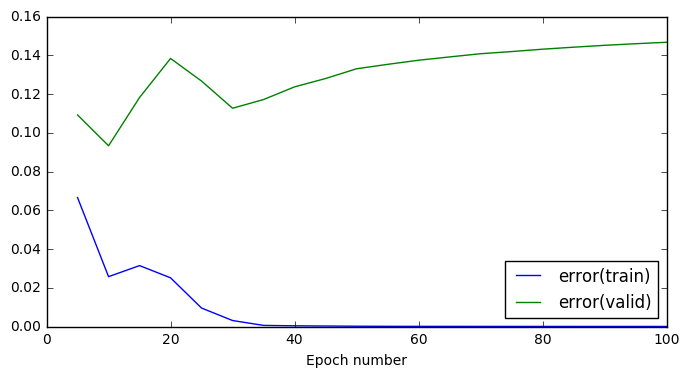

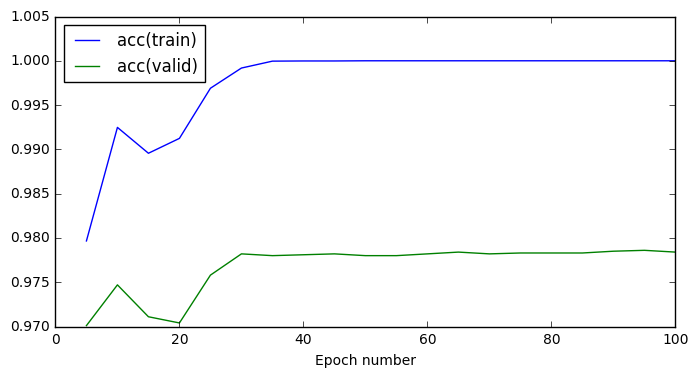

In [68]:
num_epochs = 100

learningRate = 1.1
learningRule = GradientDescentLearningRule(learning_rate=learningRate)

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

stats, keys, runTime = trainModel(
    reconstructedModel,
    error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_7_layers_100_per_layer_nonlinear_pretrain_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_7_layers_100_per_layer_nonlinear_pretrain_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

We see that the non linear stacked autoencoder yields better results. Even with 7 layers there is no phase where we have slow-training. The training reachs optimal error and accuracy at around 30 epochs. We have seen that indeed this pretraining brings the initial state of the neural network at a place that is suitable for our classification task.

## Experiment 2: yielding smaller error and higher accuracy by pretraining instead of randomly initializing weights

Our goal is to initialize the randomly generated weights with different seeds and see what kind of results we are getting. Then use Pretraining with Stacked Autoencoder and see the final performance

In [72]:
getWeightsInit = lambda theSeed: GlorotUniformInit(rng = np.random.RandomState(theSeed))

## 2 Layer Model with random initialization of weights with Glorot Uniform Initialization

Let's see how our two layer model behaves within 100 epochs

In [75]:
curSeed = 0

Epoch 0:
  error(train)=2.39e+00, acc(train)=1.14e-01, error(valid)=2.39e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 0.82s to complete
  error(train)=2.44e-01, acc(train)=9.30e-01, error(valid)=2.31e-01, acc(valid)=9.34e-01, params_penalty=0.00e+00
Epoch 10: 0.88s to complete
  error(train)=1.76e-01, acc(train)=9.49e-01, error(valid)=1.75e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 15: 0.82s to complete
  error(train)=1.37e-01, acc(train)=9.61e-01, error(valid)=1.43e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 20: 0.86s to complete
  error(train)=1.12e-01, acc(train)=9.69e-01, error(valid)=1.25e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 25: 0.88s to complete
  error(train)=9.32e-02, acc(train)=9.75e-01, error(valid)=1.13e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 0.82s to complete
  error(train)=7.95e-02, acc(train)=9.79e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 0.88s to complet

Run Time:
100.94737196


{'Final Testing Accuracy': 0.977799999999999,
 'Final Testing Error': 0.075975952329264115,
 'Final Training Accuracy': 0.99798000000000131,
 'Final Training Error': 0.018910997655838327}

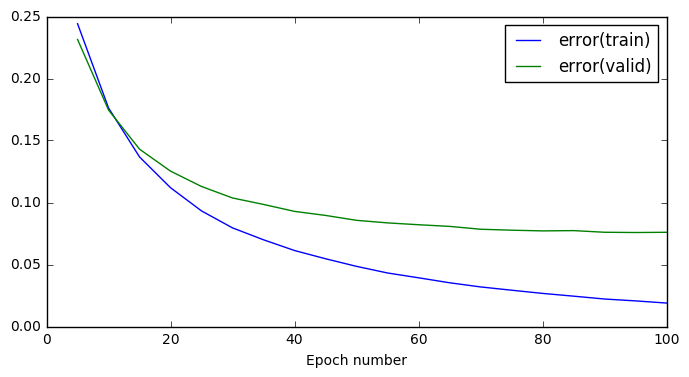

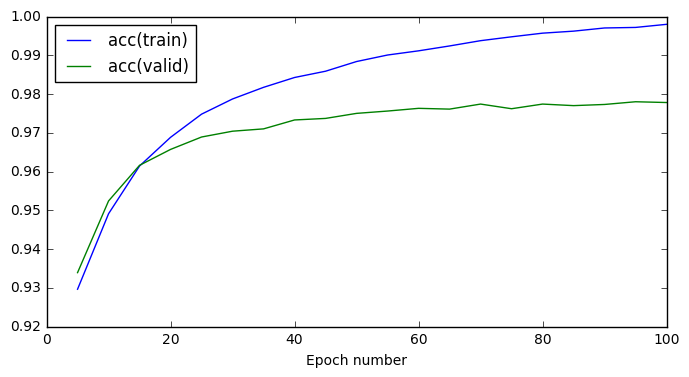

In [77]:
num_epochs = 100

input_dim, output_dim, hidden_dim = 784, 10, 100

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, getWeightsInit(curSeed), biasesInit),
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, getWeightsInit(curSeed), biasesInit)
])

learning_rate = 1e-1
learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(model, error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_2_layers_100_per_layer_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_2_layers_100_per_layer_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

After 100 epochs we have reached at ~97.78% of accuracy for our classification task

Let's repeat that for various seeds and see what we are getting

In [78]:
def fitAndScoreTwoLayer(theSeed):
    num_epochs = 100

    input_dim, output_dim, hidden_dim = 784, 10, 100

    # Multiclass classification therefore use cross-entropy + softmax error
    error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, getWeightsInit(theSeed), biasesInit),
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, getWeightsInit(theSeed), biasesInit)
    ])

    learning_rate = 1e-1
    learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys, runTime = trainModel(model, error, learningRule, trainData, validData, num_epochs, statsInterval)

    return getFinalValues(stats)

In [79]:
seeds = range(10)

finalValuesCollection = []

for curSeed in seeds:
    finalValuesCollection.append(
        fitAndScoreTwoLayer(curSeed)
    )

Epoch 0:
  error(train)=2.39e+00, acc(train)=1.14e-01, error(valid)=2.39e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 0.82s to complete
  error(train)=2.48e-01, acc(train)=9.28e-01, error(valid)=2.33e-01, acc(valid)=9.32e-01, params_penalty=0.00e+00
Epoch 10: 0.96s to complete
  error(train)=1.79e-01, acc(train)=9.48e-01, error(valid)=1.79e-01, acc(valid)=9.50e-01, params_penalty=0.00e+00
Epoch 15: 0.99s to complete
  error(train)=1.38e-01, acc(train)=9.60e-01, error(valid)=1.45e-01, acc(valid)=9.59e-01, params_penalty=0.00e+00
Epoch 20: 0.93s to complete
  error(train)=1.11e-01, acc(train)=9.69e-01, error(valid)=1.26e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 25: 0.90s to complete
  error(train)=9.36e-02, acc(train)=9.74e-01, error(valid)=1.13e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 30: 0.86s to complete
  error(train)=8.00e-02, acc(train)=9.79e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 0.91s to complet

In [95]:
print "max training accuracy"
max([x['Final Training Accuracy'] for x in finalValuesCollection])

max training accuracy


0.99794000000000105

In [80]:
accuracies = [x['Final Testing Accuracy'] for x in finalValuesCollection]
accuracies

[0.97819999999999896,
 0.97649999999999926,
 0.97779999999999856,
 0.98029999999999906,
 0.97739999999999871,
 0.97759999999999903,
 0.97809999999999941,
 0.97809999999999875,
 0.97709999999999864,
 0.97709999999999941]

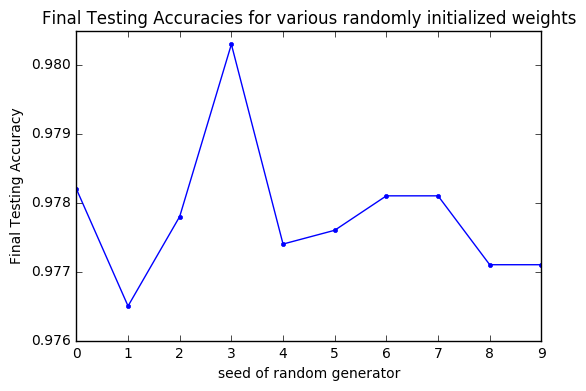

In [82]:
fig = plt.figure()
plt.title('Final Testing Accuracies for various randomly initialized weights')
plt.plot(range(len(finalValuesCollection)), accuracies, 'b.-')
plt.xlabel('seed of random generator')
plt.ylabel('Final Testing Accuracy')
plt.show()
figcount += 1
fig.savefig('experiment3_%02d.svg' % figcount)
print "figcount: " + str(figcount)

In [83]:
{
 "mean value of accuracies is": np.mean(accuracies),
 "max value of accuracies is": np.max(accuracies),
 "min value of accuracies is": np.min(accuracies)
}

{'max value of accuracies is': 0.98029999999999906,
 'mean value of accuracies is': 0.97781999999999913,
 'min value of accuracies is': 0.97649999999999926}

In [84]:
errors = [x['Final Testing Error'] for x in finalValuesCollection]
errors

[0.075947473049781125,
 0.074972005398440178,
 0.074600350138348856,
 0.072113857662326031,
 0.077269078916031825,
 0.074850175971698102,
 0.0721510299231818,
 0.073790782558457849,
 0.07628881472947617,
 0.074817650388554216]

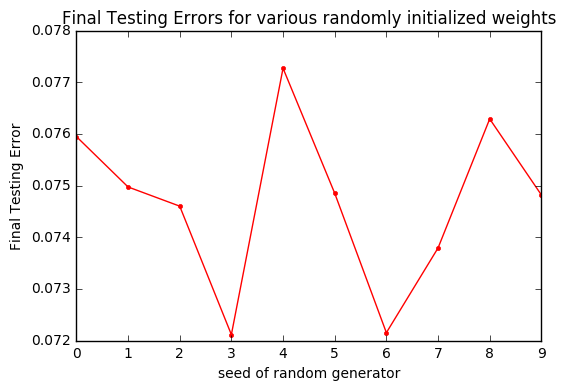

In [85]:
fig = plt.figure()
plt.title('Final Testing Errors for various randomly initialized weights')
plt.plot(range(len(finalValuesCollection)), errors, 'r.-')
plt.xlabel('seed of random generator')
plt.ylabel('Final Testing Error')
plt.show()
figcount += 1
fig.savefig('experiment3_%02d.svg' % figcount)
print "figcount: " + str(figcount)

In [86]:
{
 "mean value of errors is": np.mean(errors),
 "max value of errors is": np.max(errors),
 "min value of errors is": np.min(errors)
}

{'max value of errors is': 0.077269078916031825,
 'mean value of errors is': 0.074680121873629615,
 'min value of errors is': 0.072113857662326031}

### Pretraining with Linear Stacked AutoEncoder for 2 layers model

In [87]:
hiddenDims = np.array([100, 10])
model = constructModelFromPretrainedByAutoEncoderStack(hiddenDims, executeLinearAutoencoder)

Epoch 0:
  error(train)=5.90e+01, acc(train)=1.04e-03, params_penalty=0.00e+00
Epoch 5: 3.59s to complete
  error(train)=2.33e+00, acc(train)=1.46e-02, params_penalty=0.00e+00
Epoch 10: 3.62s to complete
  error(train)=2.33e+00, acc(train)=1.48e-02, params_penalty=0.00e+00
Epoch 15: 3.73s to complete
  error(train)=2.30e+00, acc(train)=1.42e-02, params_penalty=0.00e+00
Epoch 20: 3.76s to complete
  error(train)=2.30e+00, acc(train)=1.45e-02, params_penalty=0.00e+00
Epoch 25: 3.86s to complete
  error(train)=2.29e+00, acc(train)=1.46e-02, params_penalty=0.00e+00
Epoch 30: 3.70s to complete
  error(train)=2.30e+00, acc(train)=1.43e-02, params_penalty=0.00e+00
Epoch 0:
  error(train)=4.01e+00, acc(train)=1.63e-02, params_penalty=0.00e+00
Epoch 5: 0.50s to complete
  error(train)=1.53e+00, acc(train)=3.96e-01, params_penalty=0.00e+00
Epoch 10: 0.47s to complete
  error(train)=1.53e+00, acc(train)=4.00e-01, params_penalty=0.00e+00
Epoch 15: 0.49s to complete
  error(train)=1.53e+00, acc(tra

In [89]:
reconstructedModel = MultipleLayerModel([
        model.layers[0],
        SigmoidLayer(),
        model.layers[1]
    ])

Epoch 0:
  error(train)=2.35e+00, acc(train)=8.42e-02, error(valid)=2.35e+00, acc(valid)=8.55e-02, params_penalty=0.00e+00
Epoch 5: 0.82s to complete
  error(train)=2.48e-01, acc(train)=9.28e-01, error(valid)=2.33e-01, acc(valid)=9.33e-01, params_penalty=0.00e+00
Epoch 10: 0.91s to complete
  error(train)=1.82e-01, acc(train)=9.48e-01, error(valid)=1.79e-01, acc(valid)=9.51e-01, params_penalty=0.00e+00
Epoch 15: 0.83s to complete
  error(train)=1.42e-01, acc(train)=9.60e-01, error(valid)=1.47e-01, acc(valid)=9.59e-01, params_penalty=0.00e+00
Epoch 20: 0.83s to complete
  error(train)=1.16e-01, acc(train)=9.68e-01, error(valid)=1.28e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 25: 0.82s to complete
  error(train)=9.88e-02, acc(train)=9.73e-01, error(valid)=1.17e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 30: 0.83s to complete
  error(train)=8.40e-02, acc(train)=9.77e-01, error(valid)=1.06e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 0.84s to complet

Run Time:
109.430726051


{'Final Testing Accuracy': 0.97599999999999953,
 'Final Testing Error': 0.078078184409615808,
 'Final Training Accuracy': 0.99732000000000143,
 'Final Training Error': 0.019946441428011188}

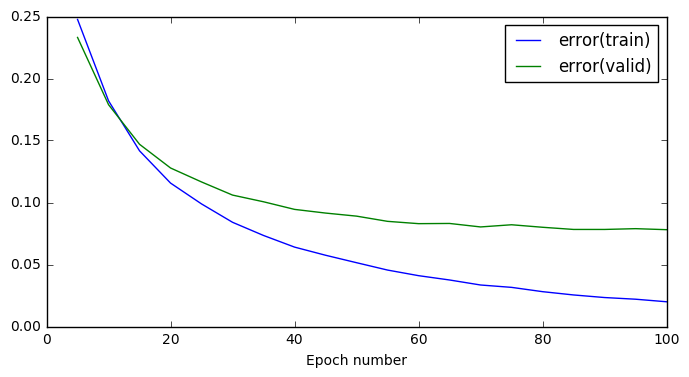

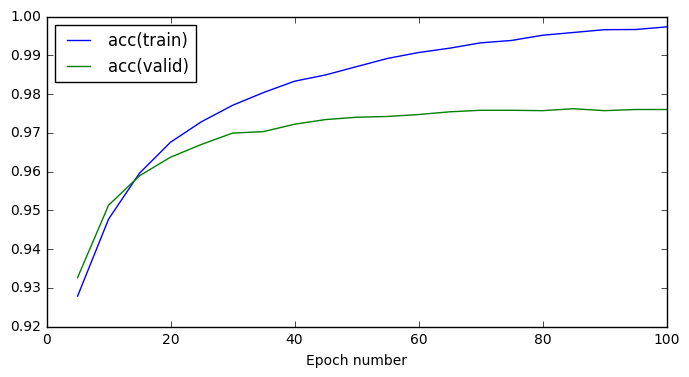

In [90]:
num_epochs = 100

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

learning_rate = 1e-1
learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(reconstructedModel,
                                  error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_2_layers_100_per_layer_linear_pretraining_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_2_layers_100_per_layer_linear_pretraining_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

For the pretraining with the linear stacked autoencoder yielded a little bit higher final testing error and the accuracy is not spectacular it is only 97.5 percent which is lower than the minimum value of our previous experiment.

We cannot make any conclusions based on this data. The result of this experiment is that random or pretraining is the same.

Below we are going to try again but using our Non-Linear Stacked AutoEncoder this time.

### Pretraining with Non Linear Stacked AutoEncoder for 2 layers model

In [91]:
hiddenDims = np.array([100, 10])
model = constructModelFromPretrainedByAutoEncoderStack(hiddenDims, executeNonLinearAutoencoder)

Epoch 0:
  error(train)=9.18e+01, acc(train)=7.60e-03, params_penalty=0.00e+00
Epoch 5: 5.44s to complete
  error(train)=3.78e+00, acc(train)=1.32e-02, params_penalty=0.00e+00
Epoch 10: 5.89s to complete
  error(train)=2.03e+00, acc(train)=1.40e-02, params_penalty=0.00e+00
Epoch 15: 5.70s to complete
  error(train)=1.30e+00, acc(train)=1.40e-02, params_penalty=0.00e+00
Epoch 20: 5.64s to complete
  error(train)=1.10e+00, acc(train)=1.47e-02, params_penalty=0.00e+00
Epoch 25: 5.91s to complete
  error(train)=1.00e+00, acc(train)=1.43e-02, params_penalty=0.00e+00
Epoch 30: 5.56s to complete
  error(train)=9.46e-01, acc(train)=1.44e-02, params_penalty=0.00e+00
Epoch 0:
  error(train)=3.12e+00, acc(train)=1.44e-02, params_penalty=0.00e+00
Epoch 5: 1.00s to complete
  error(train)=2.17e+00, acc(train)=3.83e-02, params_penalty=0.00e+00
Epoch 10: 1.00s to complete
  error(train)=2.13e+00, acc(train)=3.99e-02, params_penalty=0.00e+00
Epoch 15: 0.89s to complete
  error(train)=2.12e+00, acc(tra

In [93]:
reconstructedModel = MultipleLayerModel(model.layers[:-1])

Epoch 0:
  error(train)=2.58e+00, acc(train)=1.20e-01, error(valid)=2.56e+00, acc(valid)=1.31e-01, params_penalty=0.00e+00
Epoch 5: 1.03s to complete
  error(train)=2.38e-01, acc(train)=9.33e-01, error(valid)=2.27e-01, acc(valid)=9.34e-01, params_penalty=0.00e+00
Epoch 10: 0.82s to complete
  error(train)=1.74e-01, acc(train)=9.51e-01, error(valid)=1.74e-01, acc(valid)=9.53e-01, params_penalty=0.00e+00
Epoch 15: 0.82s to complete
  error(train)=1.37e-01, acc(train)=9.61e-01, error(valid)=1.45e-01, acc(valid)=9.60e-01, params_penalty=0.00e+00
Epoch 20: 0.90s to complete
  error(train)=1.12e-01, acc(train)=9.69e-01, error(valid)=1.28e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 25: 1.18s to complete
  error(train)=9.51e-02, acc(train)=9.74e-01, error(valid)=1.17e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 30: 1.06s to complete
  error(train)=8.12e-02, acc(train)=9.79e-01, error(valid)=1.07e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 35: 0.83s to complet

Run Time:
105.42065382


{'Final Testing Accuracy': 0.97489999999999899,
 'Final Testing Error': 0.086489229187371397,
 'Final Training Accuracy': 0.99738000000000171,
 'Final Training Error': 0.019723287982389089}

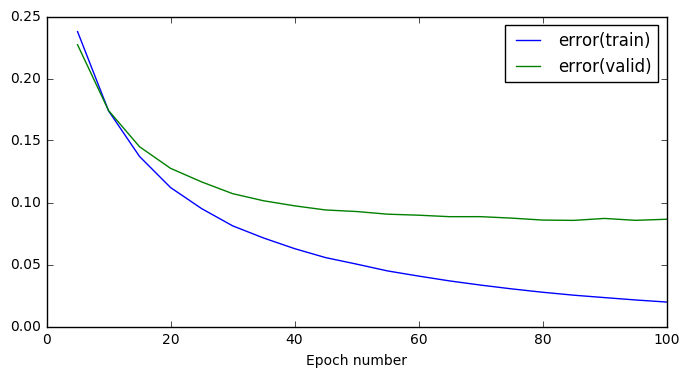

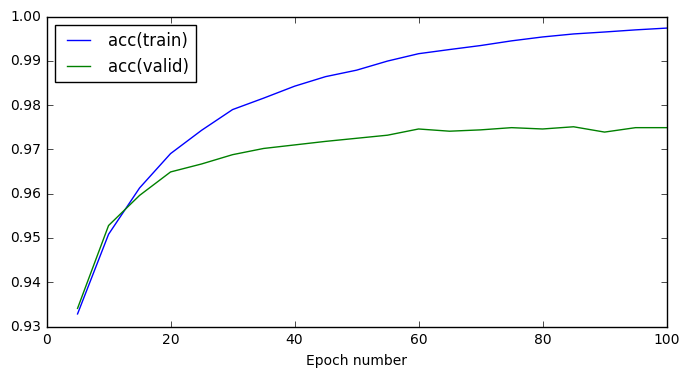

In [94]:
num_epochs = 100

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

learning_rate = 1e-1
learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(reconstructedModel,
                                  error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_2_layers_100_per_layer_nonlinear_pretraining_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_2_layers_100_per_layer_nonlinear_pretraining_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

We see again that for two layers the pretraining did not yield any spectacular results.

So for two layers we can conclude that pretraining either with linear or non-linear stacked autoencoder does not yield any better results

## 3 Layer Model with random initialization of weights with Glorot Uniform Initialization

Let's see how our three layer model behaves within 100 epochs

In [97]:
curSeed = 0

Epoch 0:
  error(train)=2.40e+00, acc(train)=1.17e-01, error(valid)=2.40e+00, acc(valid)=1.10e-01, params_penalty=0.00e+00
Epoch 5: 1.18s to complete
  error(train)=2.60e-01, acc(train)=9.24e-01, error(valid)=2.44e-01, acc(valid)=9.29e-01, params_penalty=0.00e+00
Epoch 10: 1.16s to complete
  error(train)=1.78e-01, acc(train)=9.48e-01, error(valid)=1.73e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 15: 1.15s to complete
  error(train)=1.32e-01, acc(train)=9.62e-01, error(valid)=1.39e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 20: 1.17s to complete
  error(train)=1.03e-01, acc(train)=9.70e-01, error(valid)=1.20e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 25: 1.30s to complete
  error(train)=7.84e-02, acc(train)=9.78e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 30: 1.12s to complete
  error(train)=6.29e-02, acc(train)=9.83e-01, error(valid)=9.56e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 35: 1.22s to complet

Run Time:
135.340310097


{'Final Testing Accuracy': 0.97819999999999885,
 'Final Testing Error': 0.086445198691026223,
 'Final Training Accuracy': 0.99982000000000015,
 'Final Training Error': 0.0054701150388275039}

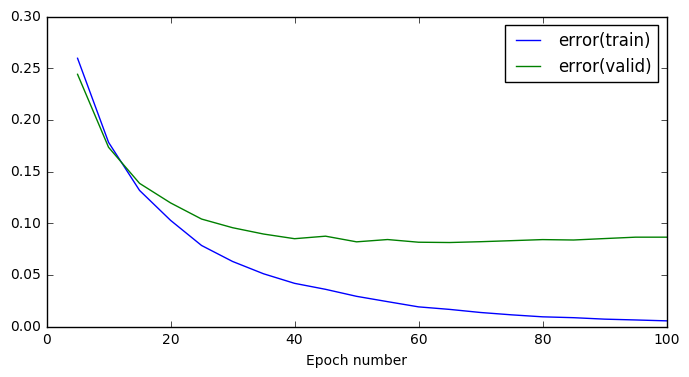

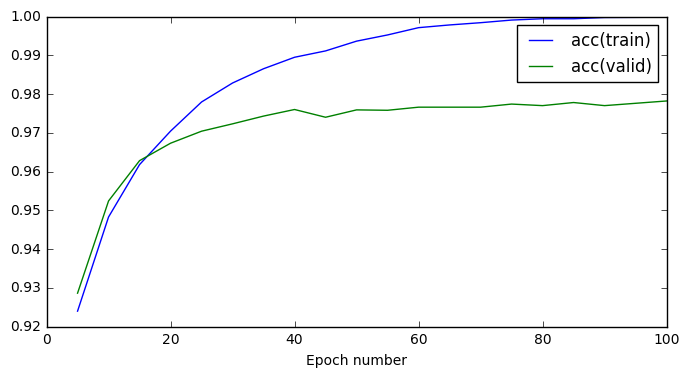

In [98]:
num_epochs = 100

input_dim, output_dim, hidden_dim = 784, 10, 100

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, getWeightsInit(curSeed), biasesInit),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, getWeightsInit(curSeed), biasesInit),
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, getWeightsInit(curSeed), biasesInit)
])

learning_rate = 1e-1
learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(model, error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_3_layers_100_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_3_layers_100_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

After 100 epochs we have reached at ~97.78% of accuracy for our classification task

Let's repeat that for various seeds and see what we are getting

Note that because on the last experiment we have slightly overfitted, we are going to run all the experiments below for 10 epochs

In [119]:
num_epochs = 10

In [120]:
def fitAndScoreThreeLayer(theSeed):
    input_dim, output_dim, hidden_dim = 784, 10, 100

    # Multiclass classification therefore use cross-entropy + softmax error
    error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, getWeightsInit(theSeed), biasesInit),
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, getWeightsInit(theSeed), biasesInit),
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, getWeightsInit(theSeed), biasesInit)
    ])

    learning_rate = 1e-1
    learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys, runTime = trainModel(model, error, learningRule, trainData, validData, num_epochs, statsInterval)

    return getFinalValues(stats)

In [121]:
seeds = range(10)

finalValuesCollection = []

for curSeed in seeds:
    finalValuesCollection.append(
        fitAndScoreThreeLayer(curSeed)
    )

Epoch 0:
  error(train)=2.40e+00, acc(train)=1.17e-01, error(valid)=2.40e+00, acc(valid)=1.10e-01, params_penalty=0.00e+00
Epoch 5: 1.45s to complete
  error(train)=2.57e-01, acc(train)=9.26e-01, error(valid)=2.41e-01, acc(valid)=9.29e-01, params_penalty=0.00e+00
Epoch 10: 1.22s to complete
  error(train)=1.76e-01, acc(train)=9.48e-01, error(valid)=1.73e-01, acc(valid)=9.51e-01, params_penalty=0.00e+00
Epoch 0:
  error(train)=2.51e+00, acc(train)=9.94e-02, error(valid)=2.50e+00, acc(valid)=9.90e-02, params_penalty=0.00e+00
Epoch 5: 1.42s to complete
  error(train)=2.60e-01, acc(train)=9.24e-01, error(valid)=2.47e-01, acc(valid)=9.30e-01, params_penalty=0.00e+00
Epoch 10: 1.20s to complete
  error(train)=1.74e-01, acc(train)=9.49e-01, error(valid)=1.70e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 0:
  error(train)=2.72e+00, acc(train)=9.72e-02, error(valid)=2.72e+00, acc(valid)=9.83e-02, params_penalty=0.00e+00
Epoch 5: 1.21s to complete
  error(train)=2.54e-01, acc(train)=9.

In [122]:
print "max training accuracy"
max([x['Final Training Accuracy'] for x in finalValuesCollection])

max training accuracy


0.95086000000000892

In [123]:
accuracies = [x['Final Testing Accuracy'] for x in finalValuesCollection]
accuracies

[0.95099999999999918,
 0.95219999999999883,
 0.95159999999999956,
 0.95429999999999893,
 0.95299999999999907,
 0.9509999999999994,
 0.95349999999999879,
 0.95379999999999954,
 0.95199999999999929,
 0.95149999999999846]

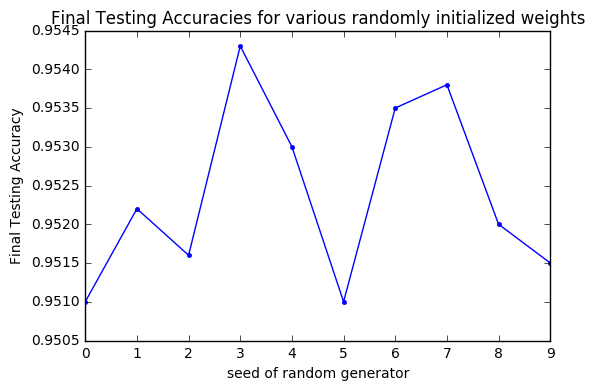

In [124]:
fig = plt.figure()
plt.title('Final Testing Accuracies for various randomly initialized weights')
plt.plot(range(len(finalValuesCollection)), accuracies, 'b.-')
plt.xlabel('seed of random generator')
plt.ylabel('Final Testing Accuracy')
plt.show()
figcount += 1
fig.savefig('experiment3_%02d.svg' % figcount)
print "figcount: " + str(figcount)

In [125]:
{
 "mean value of accuracies is": np.mean(accuracies),
 "max value of accuracies is": np.max(accuracies),
 "min value of accuracies is": np.min(accuracies)
}

{'max value of accuracies is': 0.95429999999999893,
 'mean value of accuracies is': 0.95238999999999907,
 'min value of accuracies is': 0.95099999999999918}

In [126]:
errors = [x['Final Testing Error'] for x in finalValuesCollection]
errors

[0.17292597145594951,
 0.17040377809173088,
 0.17275748249537062,
 0.1673827158389628,
 0.16892754065309096,
 0.17242892160636206,
 0.16814930826501795,
 0.17152468544856217,
 0.17011300777487798,
 0.17148803624850104]

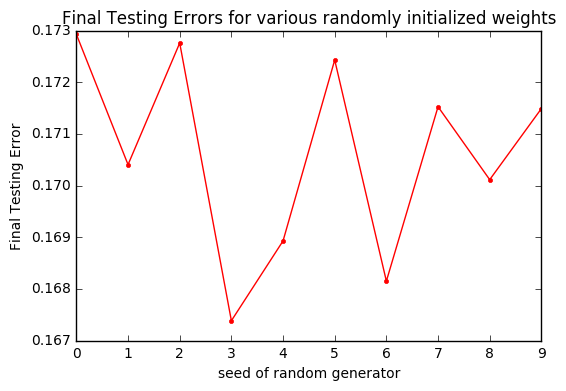

In [127]:
fig = plt.figure()
plt.title('Final Testing Errors for various randomly initialized weights')
plt.plot(range(len(finalValuesCollection)), errors, 'r.-')
plt.xlabel('seed of random generator')
plt.ylabel('Final Testing Error')
plt.show()
figcount += 1
fig.savefig('experiment3_%02d.svg' % figcount)
print "figcount: " + str(figcount)

In [128]:
{
 "mean value of errors is": np.mean(errors),
 "max value of errors is": np.max(errors),
 "min value of errors is": np.min(errors)
}

{'max value of errors is': 0.17292597145594951,
 'mean value of errors is': 0.17061014478784259,
 'min value of errors is': 0.1673827158389628}

### Pretraining with Linear Stacked AutoEncoder for 3 layers model for 10 epochs

In [129]:
hiddenDims = np.array([100, 100, 10])
model = constructModelFromPretrainedByAutoEncoderStack(hiddenDims, executeLinearAutoencoder)

Epoch 0:
  error(train)=6.09e+01, acc(train)=1.12e-03, params_penalty=0.00e+00
Epoch 5: 5.24s to complete
  error(train)=2.32e+00, acc(train)=1.44e-02, params_penalty=0.00e+00
Epoch 10: 3.51s to complete
  error(train)=2.32e+00, acc(train)=1.45e-02, params_penalty=0.00e+00
Epoch 15: 3.66s to complete
  error(train)=2.31e+00, acc(train)=1.44e-02, params_penalty=0.00e+00
Epoch 20: 3.53s to complete
  error(train)=2.30e+00, acc(train)=1.46e-02, params_penalty=0.00e+00
Epoch 25: 3.67s to complete
  error(train)=2.30e+00, acc(train)=1.48e-02, params_penalty=0.00e+00
Epoch 30: 3.93s to complete
  error(train)=2.30e+00, acc(train)=1.43e-02, params_penalty=0.00e+00
Epoch 0:
  error(train)=6.06e+00, acc(train)=7.70e-03, params_penalty=0.00e+00
Epoch 5: 0.81s to complete
  error(train)=2.02e-30, acc(train)=1.00e+00, params_penalty=0.00e+00
Epoch 10: 0.76s to complete
  error(train)=1.86e-04, acc(train)=9.93e-01, params_penalty=0.00e+00
Epoch 15: 0.80s to complete
  error(train)=2.61e-04, acc(tra

In [130]:
reconstructedModel = MultipleLayerModel([
        model.layers[0],
        SigmoidLayer(),
        model.layers[1],
        SigmoidLayer(),
        model.layers[2]
    ])

Epoch 0:
  error(train)=2.38e+00, acc(train)=1.02e-01, error(valid)=2.39e+00, acc(valid)=1.03e-01, params_penalty=0.00e+00
Epoch 5: 1.19s to complete
  error(train)=2.84e-01, acc(train)=9.19e-01, error(valid)=2.66e-01, acc(valid)=9.23e-01, params_penalty=0.00e+00
Epoch 10: 1.12s to complete
  error(train)=1.80e-01, acc(train)=9.47e-01, error(valid)=1.75e-01, acc(valid)=9.51e-01, params_penalty=0.00e+00


Run Time:
13.722796917


{'Final Testing Accuracy': 0.95109999999999995,
 'Final Testing Error': 0.1750346222970541,
 'Final Training Accuracy': 0.94718000000000802,
 'Final Training Error': 0.18039104770569661}

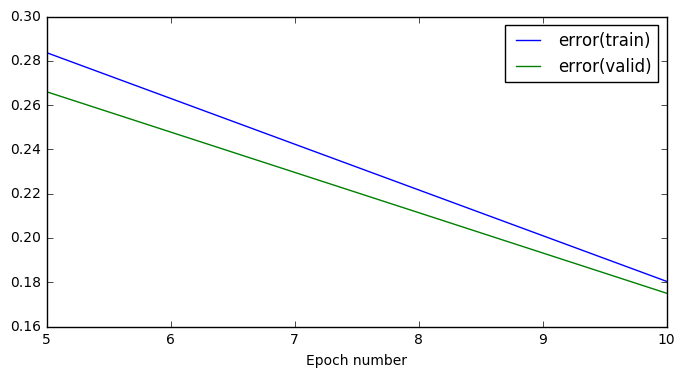

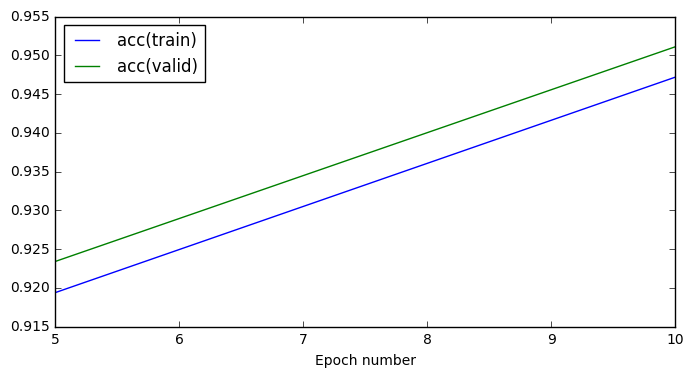

In [131]:
# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

learning_rate = 1e-1
learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(reconstructedModel,
                                  error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_3_layers_100_linear_pretraining_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_3_layers_100_linear_pretraining_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

We have similar results as with the experiment with 2 layers. The final result seems not to be better than the random weights

### Pretraining with Non Linear Stacked AutoEncoder for 3 layers model

In [132]:
hiddenDims = np.array([100, 100, 10])
model = constructModelFromPretrainedByAutoEncoderStack(hiddenDims, executeNonLinearAutoencoder)

Epoch 0:
  error(train)=9.30e+01, acc(train)=0.00e+00, params_penalty=0.00e+00
Epoch 5: 4.86s to complete
  error(train)=3.94e+00, acc(train)=1.29e-02, params_penalty=0.00e+00
Epoch 10: 5.19s to complete
  error(train)=2.05e+00, acc(train)=1.34e-02, params_penalty=0.00e+00
Epoch 15: 5.11s to complete
  error(train)=1.29e+00, acc(train)=1.42e-02, params_penalty=0.00e+00
Epoch 20: 5.02s to complete
  error(train)=1.09e+00, acc(train)=1.51e-02, params_penalty=0.00e+00
Epoch 25: 4.92s to complete
  error(train)=9.99e-01, acc(train)=1.41e-02, params_penalty=0.00e+00
Epoch 30: 4.89s to complete
  error(train)=9.36e-01, acc(train)=1.48e-02, params_penalty=0.00e+00
Epoch 0:
  error(train)=3.63e+00, acc(train)=9.48e-03, params_penalty=0.00e+00
Epoch 5: 1.18s to complete
  error(train)=1.30e-01, acc(train)=4.18e-01, params_penalty=0.00e+00
Epoch 10: 1.18s to complete
  error(train)=5.35e-02, acc(train)=5.71e-01, params_penalty=0.00e+00
Epoch 15: 1.23s to complete
  error(train)=4.17e-02, acc(tra

In [133]:
reconstructedModel = MultipleLayerModel(model.layers[:-1])

Epoch 0:
  error(train)=2.42e+00, acc(train)=9.16e-02, error(valid)=2.41e+00, acc(valid)=9.20e-02, params_penalty=0.00e+00
Epoch 5: 1.16s to complete
  error(train)=2.19e-01, acc(train)=9.38e-01, error(valid)=2.13e-01, acc(valid)=9.39e-01, params_penalty=0.00e+00
Epoch 10: 1.42s to complete
  error(train)=1.52e-01, acc(train)=9.57e-01, error(valid)=1.59e-01, acc(valid)=9.56e-01, params_penalty=0.00e+00


Run Time:
13.9135508537


{'Final Testing Accuracy': 0.95599999999999885,
 'Final Testing Error': 0.15910668025852104,
 'Final Training Accuracy': 0.95676000000000783,
 'Final Training Error': 0.15180111653825909}

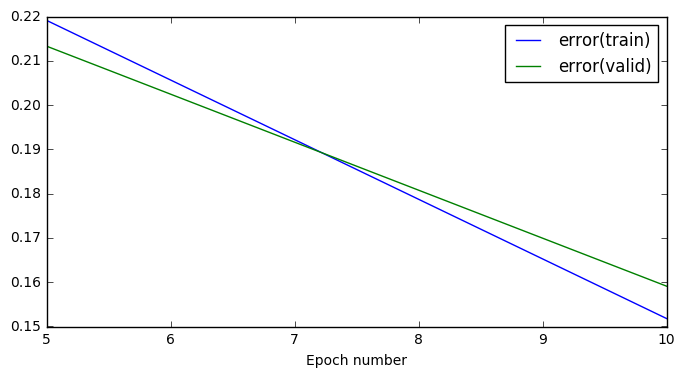

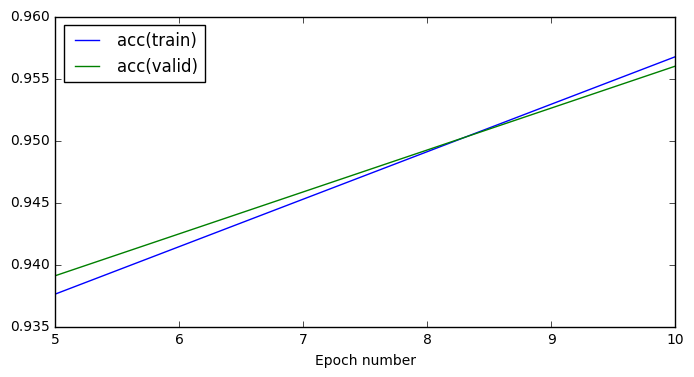

In [134]:
# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError() #this does not contain any immutable data that's why it can be set only once

learning_rate = 1e-1
learningRule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, runTime = trainModel(reconstructedModel,
                                  error, learningRule, trainData, validData, num_epochs, statsInterval)

fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys, statsInterval)
figcount += 1
fig_1.savefig('experiment3_%02d_3_layers_100_nonlinear_pretraining_fig1.svg' % figcount)
fig_2.savefig('experiment3_%02d_3_layers_100_nonlinear_pretraining_fig2.svg' % figcount)

print "figcount: " + str(figcount)
print "Run Time:"
print runTime

getFinalValues(stats)

We have similar results as with the experiment with 2 layers. The final result seems not to be better than the random weights